# SQUAD ( _Standardized qualitative dynamical systems_) implementation

## Some examples of how to qualitatively model regulatory networks using SQUAD

The following R code summarizes the implementation of the SQUAD method and presents two examples, the first simulating the effect of small and high intensity perturbations over the nodes of a regulatory network toy model and the second describing a known biological system: the regulatory network controlling terminal B cell differentiation as described in the Chapter: __ _"The SQUAD method for the qualitative analysis of regulatory networks"._ __

# Simulating the dynamical behavior of a small regulatory network

The following example explains how to simulate the dynamics of a small regulatory network using SQUAD. 

The first step to construct a qualitative model of a regulatory network with the SQUAD method is to define the regulatory network structure by postulating both the connectivity of the regulatory network (for example, which molecules activate or inhibit each other) and the corresponding logic rules (summarizing how the state of a molecule is controlled in terms of the state of its regulators). Taken toghether, the SQUAD method creates an ODEs system for all nodes of the network. The model integrates the connectivity and flow of information of the network.


## Architecture of the regulatory network.
Red diamonds represent inhibitory interactions and green arrows represent activating interactions

<img src='./images/NetworkExample.png' width=250>

## Logic rules
Logic rules controlling the activation state of each node are expressed in terms of Fuzzy logic operators

$$\omega_{A} = min(max(X, A),1-B), \omega_{B}= min(max(Y,B),1-A), \omega_{X}= min(A,1-Z), \omega_{Y}= min(B,1-A),    \omega_{Z}= B $$  


## The SQUAD function
The SQUAD function serves as a standardized skeleton allowing to translate the logic rules of the regulatory network into a continuous dynamical system by the use of the following equation:

$$ \frac{dx_k}{dt} = \frac{- e^{0.5h_k} + e^{-h_k(\omega_k - 0.5)}}{(1 - e^{0.5h_k})(1 + e^{-h_k(\omega_k-0.5)})} - {\gamma_k}x_k $$

The rate of change of each $x_k$ node is controlled by an activation and a decay term. This function defines a sigmoid curve where the parameter $h_k$ controls the stepness of the function. For high values of $h_k$ the function resembles a step function charachteristic of Boolean models. The logic rules summarizing the regulation of each node are included in the $\omega_k$ parameter, while the decay rate of the node is controlled by the $\gamma_k$ parameter.

## R code

In [68]:
#Load required packages
library(deSolve)
library(reshape2)
library(ggplot2)
library(ggthemes)
library(plyr)
library(colorRamps)

# Define SQUAD generic function to generate an ODE for each node of the regulatory network
SQUAD<-function(x,w,gamma,h){
  val<- ((-exp(0.5*h) + exp(-h*(w-0.5))) / ((1-exp(0.5*h)) * (1+exp(-h*(w-0.5))))) - (gamma*x)
  return(val)
}

The __ _SQUAD()_ __ function generates an standardized differential equation for each node. 
The resulting ODEs system will then be numerically solved with the "ode" function of the "_deSolve_" package. See [_deSolve_]('https://cran.r-project.org/web/packages/deSolve/vignettes/deSolve.pdf') package help for more information regarding ODEs system construction.


In [10]:
network<-function(t, state, parameters) {
  with(as.list(c(state, parameters)),{
    #Define the Fuzzy logic rules summarizing the regulatory information for each node
    #Classic logic operators AND, OR and NOT are translated into its Fuzzy logic equivalent by the use of the min(), max(), and 1-f() functions, respectively. 
    w_A<- min(max(X, A),1-B)
    w_B<- min(max(Y,B),1-A)
    w_X<- min(A,1-Z)
    w_Y<- min(B,1-A)
    w_Z<- B  
    #Model equations of the ODEs system using SQUAD
    dA<- SQUAD(A, w_A, gamma, h)
    dB<- SQUAD(B, w_B, gamma, h)
    dX<- SQUAD(X, w_X, gamma, h)
    dY<- SQUAD(Y, w_Y, gamma, h)
    dZ<- SQUAD(Z, w_Z, gamma, h)
    #ODE derivatives describing the dynamics of the nodes are returned as a list
    return(list(c(dA, dB, dX, dY, dZ)))})}



The "network" structure defines an ODEs system including the fuzzy logic rules postulated for each node as well as general simulation parameters and the corresponding derivatives controlled by the _SQUAD( )_ function. In this example we want to simulate the dynamical behavior of the regulatory network under the presence of specific external perturbations that may attain different levels of strength and duration. For that, we define a function to generate such perturbations. 

The ___perturbNodes()___ function creates an 'event' structure as implemented in the deSolve package to apply 
the desired perturbations to the ODEs system at specific times. Each perturbation may attain multiple values of strength and duration.
See the "events" section from the [_deSolve_]("https://cran.r-project.org/web/packages/deSolve/deSolve.pdf") package for more information.


In [15]:
perturbNodes<-function(nodes, at.times, duration, intensity, time.step.size, times){
    pulses<-vars<-values<-NULL
      for(i in 1:length(nodes)){
        #Adjust the interval of each perturbation by its duration in time steps.
        adjusted.time<-(at.times[i]/time.step.size) +1
        interval<-(duration[i]/time.step.size)
        pulse<-seq(adjusted.time, adjusted.time + interval, by=time.step.size)
        pulses<-c(pulses,times[pulse])
        vars<-c(vars,rep(nodes[i],length(pulse)))
        values<-c(values, rep(intensity[i], length(pulse)))
        }          
  return(data.frame(var=vars, time=pulses, value=values, method=rep("rep", length(pulses))))
}

In [19]:
#Time course plot function for the ODEs system simulation
plotPerturbation<-function(data, title, xlabel, ylabel){
  data<-melt(as.data.frame(data), id.vars="time")
  p<-ggplot(data = data, aes(x=time,y=value, colour=variable))
  p<-p+geom_point(size=1.0,alpha=0)+geom_path(size=1.5,alpha=1.0)
  p<- p + scale_colour_brewer(palette = "Set1")
  p<-p+theme_tufte()
  p<-p+scale_y_continuous(limits=c(0,1.0))+scale_x_continuous(limits=c(0,30))
  p<-p+labs(list(title=title,x=xlabel,y=ylabel, colour=""))
  return(p)}


# Define SQUAD function parameters
parameters <- c(h = 50,gamma = 1)

#Time step size for the numerical solving of the ODEs system
time.step.size<-0.01

#Time interval to analyze the dynamic behavior of the regulatory network
times <- seq(0,30,by=time.step.size)

#Define the initial state from which to start the simulation
initial.state<-c(A=0, B=0, X=0, Y=0, Z=0)


To generate a perturbation of the regulatory network use the ___perturbNodes()___ function:
Specify which "nodes" of the network to perturb (as a character string), the times at which the perturbations will be applied ("_at.times_") which will be adjusted according to the time step size of the ODEs system.
The "_duration_" (how many time units) and the "_intensity_" values for each perturbation.
## Small perturbation example: 
### Simulate 'low' intensity perturbations with values  0< intensity < 0.5  for the "X" and "Y" nodes, respectively.
Examples based on Fig. 5 from the Chapter: ___"The SQUAD method for the qualitative analysis of regulatory networks"___.
In the following example a small intensity perturbatios of the "X" and "Y" nodes is simulated by altering its values to 0.25. The "X" node is altered first at time 10 (of arbitrary time units), followed by an alteration of node "Y". Both signals are set to last 1 simulation time steps or 0.1 arbitrary time units:

In [32]:
perturbation_small<-perturbNodes(nodes=c("X", "Y"),at.times=c(10,20), duration=c(0.1,0.1), intensity=c(0.25,0.25), time.step.size, times)

Simulate the dynamics of the regulatory network by numerically solving the system from an initial state and under the perturbation events previously generated with the ___preturbNodes()___ function.
Dynamical simulation of the ODEs system using SQUAD:

In [33]:
dynamics.small.perturbation <- ode(y=initial.state,times=time,func=network,parms=parameters, events=list(data=perturbation_small), rtol=10e-6, atol=10e-6)


Plot the time course dynamics of the regulatory network for the example of small intensity perturbations:

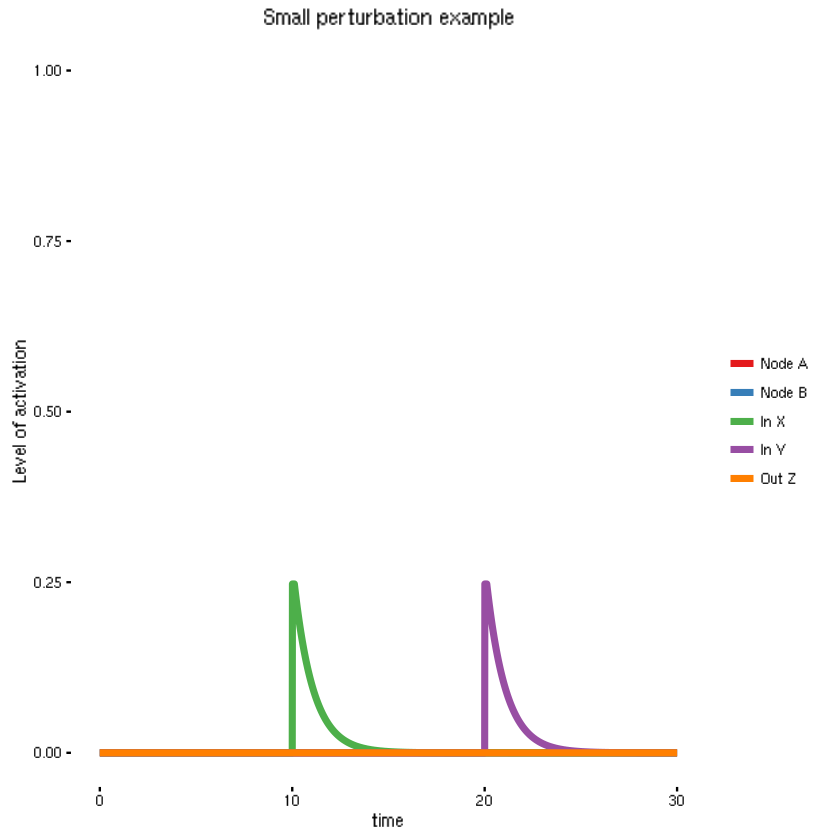

In [34]:
colnames(dynamics.small.perturbation)<-c("time", "Node A", "Node B", "In X", "In Y", "Out Z")
plotPerturbation(dynamics.small.perturbation, title="Small perturbation example", xlabel = "time", ylabel = "Level of activation")

### Simulate perturbations with different order of appearence and intensity 
In the following example the input node "X" precedes a perturbation of the node "Y". Both signals attain "high" activation values i.e., they have a value of 1.0.

In [29]:
perturbation_X_first<-perturbNodes(nodes=c("X", "Y"),at.times=c(10,20), duration=c(0.1,0.1), intensity=c(1.0,1.0), time.step.size, times)

Dynamical simulation of the ODEs system using SQUAD

In [30]:
dynamics.X.first  <- ode(y=initial.state,times=time,func=network,parms=parameters, events=list(data=perturbation_X_first), rtol=10e-6, atol=10e-6)

Plot the effect of a high intensity perturbation of the node "X" preceding a perturbation of node "Y".

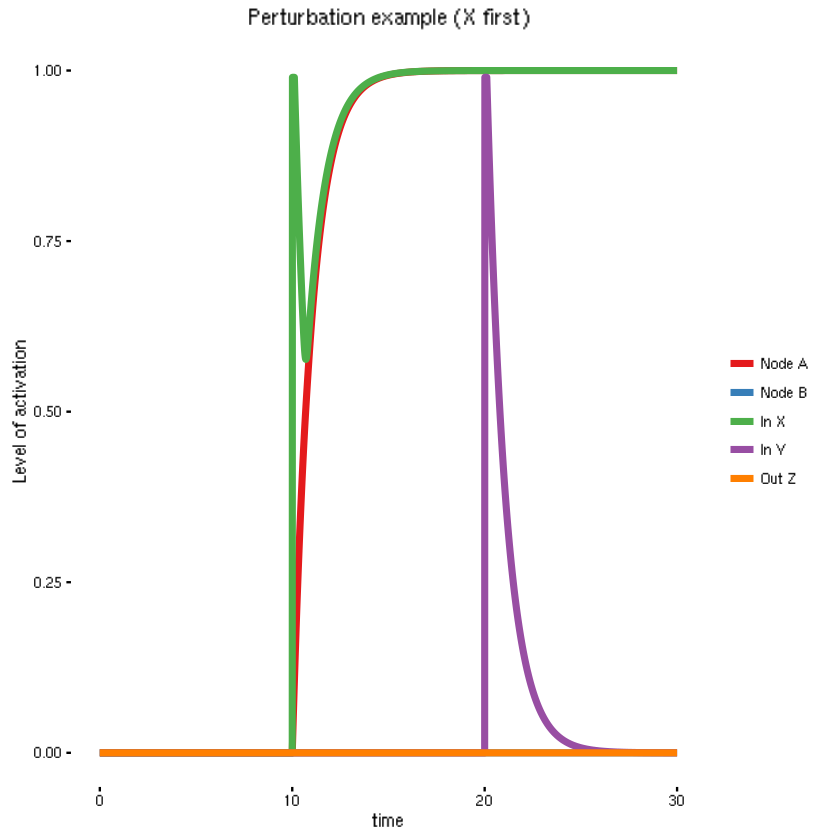

In [31]:
colnames(dynamics.X.first)<-c("time", "Node A", "Node B", "In X", "In Y", "Out Z")
plotPerturbation(dynamics.X.first, title="Perturbation example (X first)", xlabel = "time", ylabel = "Level of activation")

Now, simulate the same perturbations as above but in different order of appearance, first a perturbation of node "Y" and then node "X".

In [38]:
perturbation_Y_first<-perturbNodes(nodes=c("Y", "X"),at.times=c(10,20), duration=c(0.1,0.1), intensity=c(1.0,1.0), time.step.size, times)

Dynamical simulation of the ODEs system using SQUAD

In [39]:
dynamics.Y.first  <- ode(y=initial.state,times=time,func=network,parms=parameters, events=list(data=perturbation_Y_first), rtol=10e-6, atol=10e-6)

Plot the effect of a high intensity perturbation of the node "Y" preceding a perturbation of node "X".

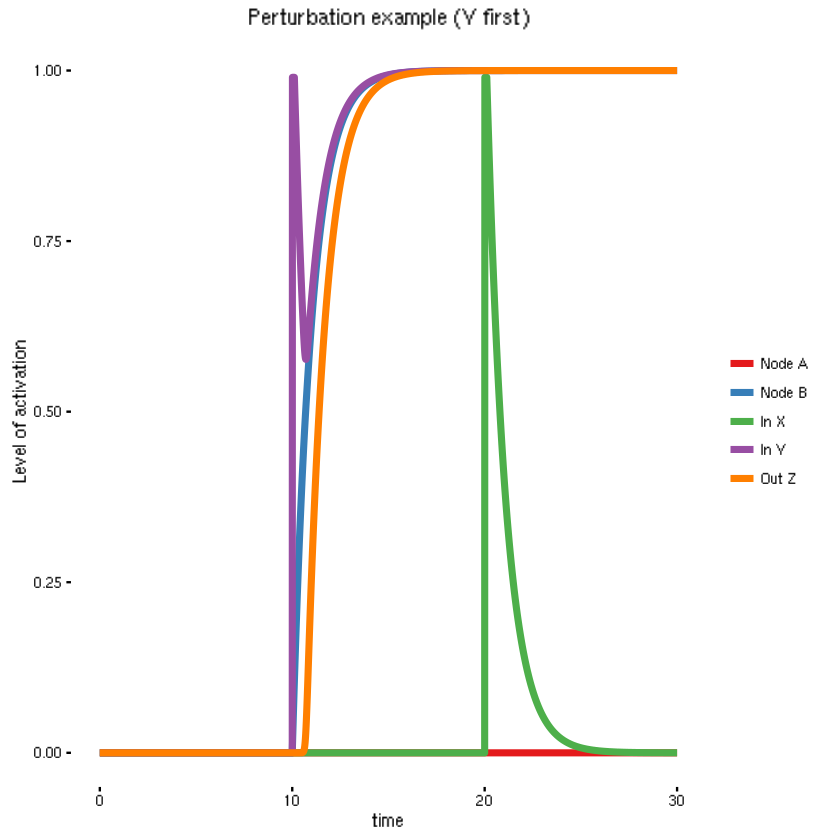

In [40]:
colnames(dynamics.Y.first)<-c("time", "Node A", "Node B", "In X", "In Y", "Out Z")
plotPerturbation(dynamics.Y.first, title="Perturbation example (Y first)", xlabel = "time", ylabel = "Level of activation")

# Example from a biological system
## Terminal B cell differentiation
The following example shows the construction of a model from the regulatory network controlling terminal B cell differentiation. The regulatory network is composed of multiple transcription factors,namely Pax5, Bach2, Bcl6, Irf4, Blimp1 and XBP1, known to be required to control the formation of particular B cell types. The model describes the differentiation process from a precursor cell type (Naive B cells) to terminally differentiated plasma cells (PC) by means of the presence of specific activation signals, see [Méndez and Mendoza]("http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004696") for more detail. 

In the next image, the activatory and inhibitory interactions are shown as green arrows and red diamonds, respectively and the rules summarizing the regulatory mechanisms among the nodes of the network are shown in the form of Fuzzy logic expressions.


<img src='./images/BCellNetwork.png' width=700>

The network presented above represents a regulatory core cotrolling the establishment of multiple steady states that characterize the multiple types of B cells (Naive, GC, Mem or PC). However, this core of regulators respond to specific external stimuli such the activation by an antigen (Ag), cytokines (IL-4, IL-21) and the direct contact with other cells (such as Th cells) mediated by the CD40L ligand. These signals can therefore, be incorporated into the model to simulate the differentiation process from the precurosor Naive B cell to terminally differentiated PC cells. 

The following figure shows the architecture of the regulatory network including the aforementioned external signals:

<img src="./images/BCellNetwork_Signals.png" width=450>

To simulate the dynamics of this regulatory network using SQUAD, we integrate the information into a "network" structure as in the first example:

In [78]:
B_cell_network<-function(t, state, parameters) {
  
  with(as.list(c(state, parameters)),{
    #Fuzzy logic rules
    #IL4 does not have input, its value is set according to the initial state parameters
    w_IL4R  <-  max(IL4)
    w_STAT6 <-  max(IL4R)
    #IL2 does not have input, its value is set according to the initial state parameters
    w_IL2R <-  max(IL2)
    w_STAT5 <-  max(IL2R)
    #IL21 does not have input, its value is set according to the initial state parameters
    w_IL21R <-  max(IL21)
    w_STAT3 <-  max(IL21R)
    #CD40L does not have input, its value is set according to the initial state parameters
    w_CD40  <-  max(CD40L)
    w_NFkB  <-  max(CD40)
    #Ag does not have input, its value is set according to the initial state parameters
    w_BCR   <-  max(Ag)
    w_ERK   <-  max(BCR)
    w_AID   <-  min(max(STAT6, min(NFkB,pax5)), 1-blimp1)
    w_bach2 <-  min(pax5,1-blimp1)
    w_bcl6  <-  min(max(STAT5,STAT6, min(pax5,bcl6)), 1-(max(blimp1,irf4,ERK)))
    w_blimp1    <- max(max(ERK,STAT3), min(irf4, 1-(max(pax5,bcl6,bach2))))
    w_irf4  <- max(max(NFkB, irf4), min(blimp1,1-bcl6))
    w_pax5  <- min(max(pax5,1-irf4),1-(max(blimp1,ERK)))  
    w_XBP1  <- min(blimp1, 1-pax5)
    #Model equations using SQUAD
    aid     <-  SQUAD(AID,w_AID,gamma,h)
    #The node Ag is an input, its rate of change is controlled only by a decay term
    ag      <-  -gamma*Ag
    Bach2   <-  SQUAD(bach2, w_bach2,gamma,h)
    Bcl6    <-  SQUAD(bcl6,w_bcl6,gamma,h)
    Blimp1  <-  SQUAD(blimp1,w_blimp1,gamma,h)
    bcr     <-  SQUAD(BCR,w_BCR,gamma,h)
    cd40    <-  SQUAD(CD40,w_CD40,gamma,h)
    #The node CD40L is an input, its rate of change is controlled only by a decay term
    cd40l   <-  -gamma*CD40L
    erk     <-  SQUAD(ERK,w_ERK,gamma,h)
    #The node IL2 is an input, its rate of change is controlled only by a decay term
    il2     <-  -gamma*IL2
    il2r    <-  SQUAD(IL2R,w_IL2R,gamma,h)
    #The node IL4 is an input, its rate of change is controlled only by a decay term
    il4     <-  -gamma*IL4
    il4r    <-  SQUAD(IL4R,w_IL4R,gamma,h)
    #The node IL21 is an input, its rate of change is controlled only by a decay term
    il21    <-  -gamma*IL21
    il21r   <-  SQUAD(IL21R,w_IL21R,gamma,h)
    Irf4    <-  SQUAD(irf4,w_irf4,gamma,h)
    nfkb    <-  SQUAD(NFkB,w_NFkB,gamma,h)
    Pax5    <-  SQUAD(pax5,w_pax5,gamma,h)
    stat3   <-  SQUAD(STAT3,w_STAT3,gamma,h)
    stat5   <-  SQUAD(STAT5,w_STAT5,gamma,h)
    stat6   <-  SQUAD(STAT6,w_STAT6,gamma,h)
    xbp1    <-  SQUAD(XBP1,w_XBP1,gamma,h)
    
    #Results are returned as a list
    return(list(c(aid, ag, Bach2, Bcl6, bcr, Blimp1, cd40, cd40l, erk, il2, il2r, il4, il4r, il21, il21r, Irf4, nfkb, Pax5, stat3, stat5, stat6,xbp1)))
    
  })
}

Define the general parameters for the simulation

In [79]:
time.step.size<-0.01

times <- round(seq(0,100, by = time.step.size), 2)

parameters <- c(h=50,gamma=1.0)

initial.state <- c(AID=0, Ag=0, bach2=1, bcl6=0, BCR=0, blimp1=0, CD40=0, CD40L=0, 
           ERK=0, IL2=0,IL2R=0, IL4=0, IL4R=0, IL21=0, IL21R=0, irf4=0, NFkB=0, 
            pax5=1, STAT3=0, STAT5=0, STAT6=0, XBP1=0)


Generate the list of perturbation events to simulate the effect of high intensity perturbations of the nodes IL4, CD40L and Ag, respectively at present at different times using the ___perturbNodes()___ function:

In [90]:
external.signals<-perturbNodes(nodes=c("IL4","CD40L","Ag"), at.times = c(25,50,75),duration = rep(2,3),intensity = rep(1.0,3), time.step.size = time.step.size, times)

Simulate the dynamical behavior of the regulatory network using SQUAD:

In [91]:
out <- ode(y=initial.state,times=times,func=B_cell_network,parms=parameters, events = list(data = external.signals), atol=10e-6, rtol=10e-6)

out.df<-melt(as.data.frame(out), id.vars="time")


Plot the time course changes of the regulatory network dynamics under the presence of external signals. 

(The ___plotHeatMap()___ funcion is useful to visualize the results as the number of nodes in the models increases)

In [85]:
plotHeatMap<-function(data, title, xlab, ylab, node.names){
  #Plot data frame in a "descendent" order
  p<-ggplot(data=data, aes(time, reorder(variable,desc(variable))))
  #geom_tile plots data by filling rectangles of a given size, 
  #size and color control the lines dividing each site in the lattice
  p<-p + geom_tile(aes(fill=value), colour="white",size=0)
  colors<-matlab.like2(1000)
  p<-p+scale_fill_gradientn("", colours = colors, limits=c(0,1), guide=guide_colorbar(draw.ulim=FALSE, draw.llim=FALSE, barwidth = 0.5, barheight = 4.0))
  #Use a fancy plot style, for more styles see ggthemes help
  p<-p+theme_tufte()
  #p<-p+theme(axis.text.x=element_text(size=rel(0.7)))
  p<-p+scale_y_discrete(labels=rev(node.names))
  #Add user dfined labels to the plot
  p<-p+labs(list(title=title,x=xlab,y=ylab, colour=""))
  #p<-p+ scale_y_discrete(labels=rev(node.names))
  return(p)
}


The simulation shows the transitions from one attractor to another by means of the presence of external signals with "high" intensity values such as IL4 (present at time 25), CD40L (time=50) and Ag (at time 75). The model describes the differentiation process starting from a precursor state (Naive B cell type) and its subsequent transition to other states (such as GC and Mem cell types, respectively) to finally transit to the terminally differentiated state corresponding to plasma cells (PC). 

The level of activation of the nodes is shown as a scale ranging from "low" (blue) to "high" (red). For simplicity the nodes are arranged alphabetically.

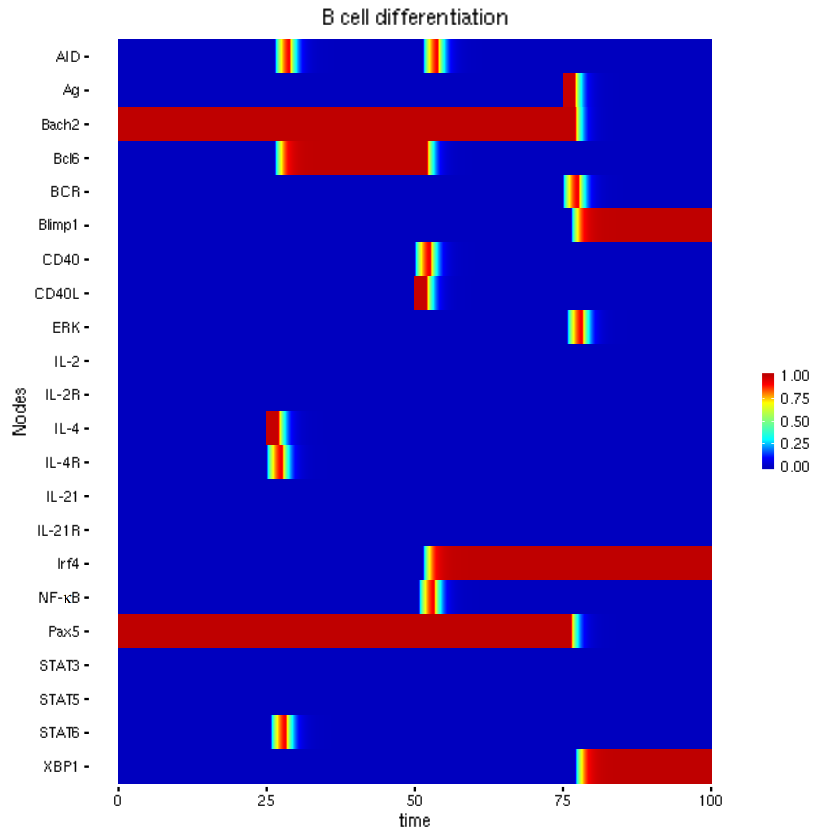

In [89]:
node.names<-c("AID", "Ag", "Bach2", "Bcl6", "BCR", "Blimp1", "CD40", "CD40L", "ERK", "IL-2","IL-2R", "IL-4", "IL-4R", "IL-21", "IL-21R", "Irf4", expression(paste("NF-",kappa,"B")), "Pax5", "STAT3", "STAT5", "STAT6", "XBP1")

plotHeatMap(out.df, title="B cell differentiation", xlab="time", ylab="Nodes", node.names)
